## RandAugmentation_simple
- baseline code가 존재하는 디렉토리에 해당 노트북을 다운받아 실행해주시기바랍니다.

In [1]:
import torch
import os
import sys
import yaml
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from typing import Tuple
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from src.utils.common import read_yaml

if "./" not in sys.path:
    sys.path.append("./")

In [2]:
from src.model import Model
from src.trainer import TorchTrainer
from src.loss import CustomCriterion
from src.dataloader import create_dataloader, get_dataset

In [3]:
MEAN_V = (0.4914, 0.4822, 0.4465)
STD_V = (0.2470, 0.2435, 0.2616)

data_config = read_yaml(cfg="configs/data/taco.yaml")

In [4]:
def tensor_to_img(tensor_img: torch.Tensor) -> np.ndarray:
    return ((tensor_img.permute(1, 2, 0).numpy() * STD_V + MEAN_V) * 255).astype(np.uint8)

def visualize_datasets(_train_dataset, _val_dataset, _test_dataset, title_prefix: str = "") -> None:
    fig, ax = plt.subplots(3, 7, figsize=(20, 10))

    for i in range(7):
        idx = np.random.randint(0, len(_val_dataset))

        ax[0][i].imshow(tensor_to_img(_train_dataset[idx][0]))
        ax[1][i].imshow(tensor_to_img(_val_dataset[idx][0]))
        ax[2][i].imshow(tensor_to_img(_test_dataset[idx][0]))

        ax[0][i].axis('off')
        ax[1][i].axis('off')
        ax[2][i].axis('off')

    fig.suptitle(f"{title_prefix} Visualization of Augmentation.\n(Each row represents train, validation, test dataset accordingly)")
    fig.show()

In [5]:
import optuna
import yaml
from src.augmentation.transforms import SquarePad, cutout

In [6]:
EPOCHS = 10
BATCH_SIZE = 256
    
def objective(trial: optuna.Trial) -> float:
    img_size = 32

    augmentation_functions = []
    use_color_jitter = trial.suggest_categorical("aug_color_jitter", [True, False])
    use_random_perspective = trial.suggest_categorical("aug_random_perspective", [True, False])
    use_random_flip = trial.suggest_categorical("aug_random_flip", [True, False])
    # -- add
    use_squarepad = trial.suggest_categorical("aug_squarepad", [True, False])
    use_cutout = trial.suggest_categorical("aug_cutout", [True, False])
    
    if use_color_jitter:
        augmentation_functions.append(transforms.ColorJitter(brightness=(0.5, 1.5), 
                                                             contrast=(0.5, 1.5), 
                                                             saturation=(0.5, 1.5)))
    if use_random_perspective:
        augmentation_functions.append(transforms.RandomPerspective())
    
    if use_random_flip:
        augmentation_functions.append(transforms.RandomHorizontalFlip())

    if use_squarepad:
        augmentation_functions.append(SquarePad())
    
    if use_cutout:
        augmentation_functions.append(cutout(magnitude=0.1))
    
        
    train_dataset, val_dataset, test_dataset = get_dataset(data_path="/opt/ml/data/", dataset_name='TACO', img_size=224)
    
    visualize_datasets(train_dataset, val_dataset, test_dataset, title_prefix=f"Trial {trial.number:03d} //")
    plt.draw()
    plt.show()
    print(augmentation_functions)
    
    with open("./configs/model/mobilenetv3.yaml", "r") as f:
        model_cfg = yaml.load(f, yaml.SafeLoader)

    model_cfg['backbone'][-1][-1] = [10]

    model = Model(model_cfg, verbose=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)

    optimizer = torch.optim.SGD(model.model.parameters(), lr=0.1, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=0.1, steps_per_epoch=len(train_dataset), epochs=EPOCHS, pct_start=0.05)
    criterion = CustomCriterion(samples_per_cls=None, device=device)

    train_loader, val_loader, test_loader = create_dataloader(data_config)

    exp_dir = "./exp/autoaug"
    os.makedirs(exp_dir, exist_ok=True)

    # Amp loss scaler
    scaler = (
        torch.cuda.amp.GradScaler() if True and device != torch.device("cpu") else None
    )
    trainer = TorchTrainer(model=model, 
                           criterion=criterion, 
                           optimizer=optimizer, 
                           scheduler=scheduler, 
                           scaler=scaler,
                           device=device, 
                           verbose=1, 
                           model_path=os.path.join(exp_dir, "best.pt"))

    best_acc, best_f1 = trainer.train(train_dataloader=train_loader, 
                                      n_epoch=EPOCHS, 
                                      val_dataloader=val_loader)
    print("TEST DATASET")
    test_loss, test_f1, test_accuracy = trainer.test(model, test_loader)
    
    return test_f1

## Run

[I 2021-11-23 18:11:12,463] A new study created in memory with name: autoaug


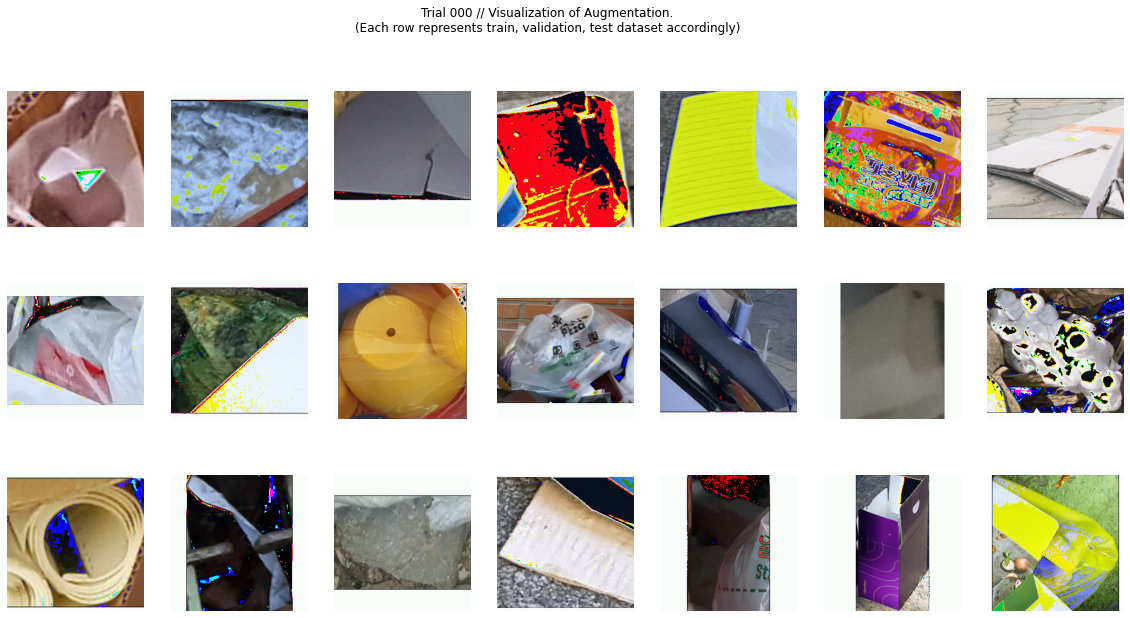

[RandomHorizontalFlip(p=0.5), <src.augmentation.transforms.SquarePad object at 0x7f29ffa7eb10>, <src.augmentation.transforms.cutout object at 0x7f29ffa7ead0>]
idx |   n |     params |          module |            arguments |   in_channel |   out_channel
----------------------------------------------------------------------------------------------
  0 |   1 |        464 |            Conv | [16, 3, 2, None, 1, 'HardSwish'] |            3           16
  1 |   1 |        464 | InvertedResidualv3 |  [3, 1, 16, 0, 0, 1] |           16           16
  2 |   1 |      3,440 | InvertedResidualv3 |  [3, 4, 24, 0, 0, 2] |           16           24
  3 |   1 |      4,440 | InvertedResidualv3 |  [3, 3, 24, 0, 0, 1] |           24           24
  4 |   1 |     10,328 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 2] |           24           40
  5 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |           40           40
  6 |   1 |     20,992 | InvertedResidualv3 |  [5, 3, 40, 1, 0, 1] |    

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jujoo (use `wandb login --relogin` to force relogin)


  0%|          | 0/244 [00:00<?, ?it/s]/opt/conda/envs/lightweight/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
Train: [001] Loss: 1.663, Acc: 39.01% F1(macro): 0.23: 100%|██████████| 244/244 [01:30<00:00,  2.69it/s]
 Val:       Loss: 2.943, Acc: 36.21% F1(macro): 0.23: 100%|██████████| 82/82 [00:44<00:00,  1.85it/s]


Model saved. Current best test f1: 0.227


Train: [002] Loss: 1.615, Acc: 43.39% F1(macro): 0.26: 100%|██████████| 244/244 [00:59<00:00,  4.14it/s]
 Val:       Loss: 98.913, Acc: 20.38% F1(macro): 0.12: 100%|██████████| 82/82 [00:27<00:00,  3.03it/s]
Train: [003] Loss: 1.599, Acc: 43.97% F1(macro): 0.26: 100%|██████████| 244/244 [00:51<00:00,  4.71it/s]
 Val:       Loss: 1.490, Acc: 46.86% F1(macro): 0.22: 100%|██████████| 82/82 [00:26<00:00,  3.12it/s]
Train: [004] Loss: 1.582, Acc: 45.33% F1(macro): 0.27: 100%|██████████| 244/244 [00:52<00:00,  4.63it/s]
 Val:       Loss: 1.555, Acc: 41.99% F1(macro): 0.22: 100%|██████████| 82/82 [00:27<00:00,  3.03it/s]
Train: [005] Loss: 1.695, Acc: 37.82% F1(macro): 0.21: 100%|██████████| 244/244 [00:52<00:00,  4.66it/s]
 Val:       Loss: 1.652, Acc: 32.11% F1(macro): 0.17: 100%|██████████| 82/82 [00:27<00:00,  3.03it/s]
Train: [006] Loss: 1.703, Acc: 37.37% F1(macro): 0.18: 100%|██████████| 244/244 [00:52<00:00,  4.61it/s]
 Val:       Loss: 1.571, Acc: 41.12% F1(macro): 0.23: 100%|███████

Model saved. Current best test f1: 0.233


Train: [007] Loss: 1.478, Acc: 42.11% F1(macro): 0.23: 100%|██████████| 244/244 [00:52<00:00,  4.62it/s]
 Val:       Loss: 1.534, Acc: 43.08% F1(macro): 0.21: 100%|██████████| 82/82 [00:26<00:00,  3.12it/s]
Train: [008] Loss: 1.427, Acc: 44.56% F1(macro): 0.26: 100%|██████████| 244/244 [00:53<00:00,  4.57it/s]
 Val:       Loss: 1.413, Acc: 45.77% F1(macro): 0.26: 100%|██████████| 82/82 [00:26<00:00,  3.12it/s]


Model saved. Current best test f1: 0.256


Train: [009] Loss: 1.410, Acc: 45.45% F1(macro): 0.27: 100%|██████████| 244/244 [00:52<00:00,  4.63it/s]
  0%|          | 0/82 [00:00<?, ?it/s]

In [7]:
study = optuna.create_study(direction="maximize", study_name="autoaug", load_if_exists=True)
study.optimize(objective, n_trials=100)